In [2]:
import pandas as pd
import numpy as np
import lifelines
from patsy import dmatrix
import matplotlib.colors as mcolors
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
from lifelines import KaplanMeierFitter
from lifelines.utils import concordance_index
from lifelines import CoxPHFitter
from sklearn.metrics import log_loss
from sklearn.metrics import brier_score_loss
import seaborn as sns

In [3]:
df_train = pd.read_csv('df_train_cph3.csv')
df_test = pd.read_csv('df_test_cph3.csv')

In [4]:
# CPH4

In [5]:
df_train_cph4 = df_train.copy()
df_test_cph4 = df_test.copy()

In [6]:
formula="bs(BMICALC, degree=2, df=3) + bs(HRSLEEP, degree=1, df=2) + bs(STRONGFWK, degree=2, df=2) + bs(ALCDAYSYR, degree=1, df=2) + bs(ALCAMT, degree=2, df=2) + bs(POVERTY, degree=2, df=2) +" + " + ".join(df_train_cph4.columns.difference(['TIMETOEVENT', 'MORTSTAT','BMICALC', 'HRSLEEP', 'STRONGFWK', 'ALCDAYSYR', 'ALCAMT', 'POVERTY']))

cph = CoxPHFitter()
cph.fit(df_train_cph4,
        duration_col='TIMETOEVENT', 
        event_col='MORTSTAT',
        formula=formula)

#cph.print_summary()

<lifelines.CoxPHFitter: fitted with 82720 total observations, 78101 right-censored observations>

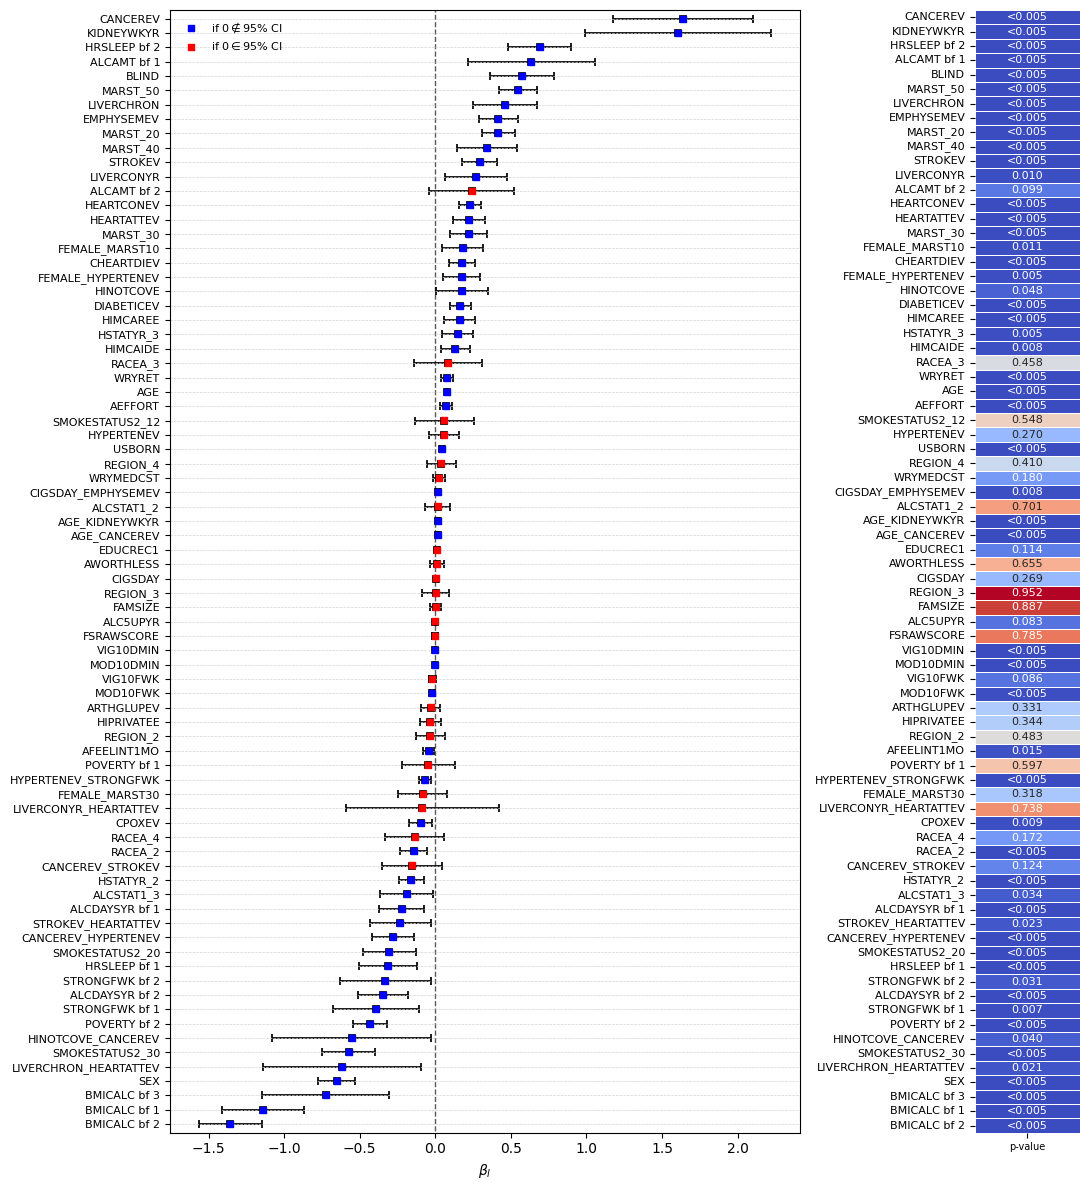

In [7]:
# extract coefficients, confidence intervals, and p-values
coefs = cph.summary[['coef', 'coef lower 95%', 'coef upper 95%']]
p_values = cph.summary[['p']] 
l95 = cph.summary[['coef lower 95%']]
u95 = cph.summary[['coef upper 95%']]

# sort indices to match coefficient plot order
coefs = coefs.sort_values(by='coef', ascending=False)
p_values = p_values.loc[coefs.index]  
l95 = l95.loc[coefs.index]
u95 = u95.loc[coefs.index]

# replace p-values < 0.005 with '<0.005' annotation
p_values_annot = p_values.apply(lambda col: col.map(lambda x: '<0.005' if x < 0.005 else f'{x:.3f}'))

# create subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(11, 12), gridspec_kw={'width_ratios': [3, 0.5]})

# ---left plot---
cph.plot(ax=ax1, linestyle="", markersize=5)  

# get x (coefs) and y positions for points
x_vals = coefs['coef']
y_vals = np.arange(len(coefs))  

# identify significant markers (e.g., p-value < 0.05)
significant = u95['coef upper 95%']*l95['coef lower 95%'] >= 0
not_significant = u95['coef upper 95%']*l95['coef lower 95%'] < 0

x_plot_sig = x_vals[significant]
y_plot_sig = len(y_vals)-1-y_vals[significant]
x_plot_not_sig = x_vals[not_significant]
y_plot_not_sig = len(y_vals)-1-y_vals[not_significant]

# highlight significant markers in red
ax1.scatter(x_plot_sig, y_plot_sig, color="blue", marker='s', s=15, label=r"if $0\notin 95\%$ CI", zorder=3) 
ax1.scatter(x_plot_not_sig, y_plot_not_sig+0.02, color="red", marker='s', s=15, label=r"if $0\in 95\%$ CI", zorder=3) 
ax1.set_xlabel(r'$\beta_l$', fontsize=10)
ax1.tick_params(axis='y', labelsize=8)  
ax1.set_ylim(-0.6, len(y_vals)-0.4) 
ax1.legend(fontsize=8, loc="upper left", frameon=False)

# add horizontal grid lines across both plots
for y in range(len(coefs)+1):
    ax1.axhline(y-1, color='lightgrey', linestyle='--', linewidth=0.5)

sns.heatmap(p_values, ax=ax2, cmap='coolwarm', annot=p_values_annot, fmt="", cbar=False, linewidths=0.7,
            annot_kws={'size': 8}) 
ax2.set_ylabel('')  
ax2.set_xticklabels(['p-value'], fontsize=8, rotation=0)

# all y-ticks  displayed on the heatmap
ax2.set_yticks(np.arange(len(p_values)) + 0.5)  
ax2.set_yticklabels(p_values.index, fontsize=8)  
ax2.tick_params(axis='both', labelsize=7)

#____________
# define custom labels for splines
spline_labels = {
    "bs(BMICALC, degree=2, df=3)[1]": "BMICALC bf 1",
    "bs(BMICALC, degree=2, df=3)[2]": "BMICALC bf 2",
    "bs(BMICALC, degree=2, df=3)[3]": "BMICALC bf 3",
    "bs(HRSLEEP, degree=1, df=2)[1]": "HRSLEEP bf 1",
    "bs(HRSLEEP, degree=1, df=2)[2]": "HRSLEEP bf 2",
    "bs(STRONGFWK, degree=2, df=2)[1]": "STRONGFWK bf 1",
    "bs(STRONGFWK, degree=2, df=2)[2]": "STRONGFWK bf 2",
    "bs(ALCDAYSYR, degree=1, df=2)[1]": "ALCDAYSYR bf 1",
    "bs(ALCDAYSYR, degree=1, df=2)[2]": "ALCDAYSYR bf 2",
    "bs(ALCAMT, degree=2, df=2)[1]": "ALCAMT bf 1", 
    "bs(ALCAMT, degree=2, df=2)[2]": "ALCAMT bf 2", 
    "bs(POVERTY, degree=2, df=2)[1]": "POVERTY bf 1",
    "bs(POVERTY, degree=2, df=2)[2]": "POVERTY bf 2",
}

# replace splines in coefficient and p-value indices
coefs.index = [spline_labels.get(x, x) for x in coefs.index]
p_values.index = coefs.index  # Ensure consistency

# update y-axis labels in both plots
ax1.set_yticklabels(coefs.index[::-1], fontsize=8) 
ax2.set_yticklabels(p_values.index, fontsize=8) 

#____________

plt.tight_layout()
plt.savefig('cph0.png', format='png', dpi=300, bbox_inches='tight')
plt.show()

In [8]:
drop_columns=['WRYMEDCST', 'EDUCREC1', 'AWORTHLESS', 'CIGSDAY', 'FAMSIZE', 'ALC5UPYR', 'FSRAWSCORE', 'VIG10FWK',
              'RACEA_3', 'SMOKESTATUS2_12', 'HYPERTENEV', 'REGION_4', 'ALCSTAT1_2', 'REGION_3', 'ARTHGLUPEV', 
              'HIPRIVATEE', 'REGION_2', 'FEMALE_MARST30', 'LIVERCONYR_HEARTATTEV', 'RACEA_4']

df_train_cph4 = df_train_cph4.drop(columns=drop_columns)
df_test_cph4 = df_test_cph4.drop(columns=drop_columns)

In [9]:
formula="bs(BMICALC, degree=2, df=3) + bs(HRSLEEP, degree=1, df=2) + bs(STRONGFWK, degree=2, df=2) + bs(ALCDAYSYR, degree=1, df=2) + bs(ALCAMT, degree=2, df=2) + bs(POVERTY, degree=2, df=2) +" + " + ".join(df_train_cph4.columns.difference(['TIMETOEVENT', 'MORTSTAT','BMICALC', 'HRSLEEP', 'STRONGFWK', 'ALCDAYSYR', 'ALCAMT', 'POVERTY']))

cph = CoxPHFitter()
cph.fit(df_train_cph4,
        duration_col='TIMETOEVENT', 
        event_col='MORTSTAT',
        formula=formula)

#cph.print_summary()

<lifelines.CoxPHFitter: fitted with 82720 total observations, 78101 right-censored observations>

In [10]:
print(f'APLL_is: {cph.score(df_train_cph4, scoring_method="log_likelihood"):.4f}')
print(f'APLL_os: {cph.score(df_test_cph4, scoring_method="log_likelihood"):.4f}')
print(f'C_is: {cph.score(df_train_cph4, scoring_method="concordance_index"):.4f}')
print(f'C_os: {cph.score(df_test_cph4, scoring_method="concordance_index"):.4f}')

APLL_is: -0.5500
APLL_os: -0.4601
C_is: 0.8862
C_os: 0.8907


In [11]:
# predict the survival function for each individual
survival_probs_16_train = cph.predict_survival_function(df_train_cph4)
survival_probs_16_test = cph.predict_survival_function(df_test_cph4)

# extract 3y survival probabilities
survival_prob_3y_train = survival_probs_16_train.iloc[3] 
survival_prob_3y_test = survival_probs_16_test.iloc[3] 

# get 3-year event status based on TIMETOEVENT and MORTSTAT
status_3y_train = np.where((df_train_cph4["MORTSTAT"] == 1) & (df_train_cph4["TIMETOEVENT"] <= 3), 0, 1)
status_3y_test = np.where((df_test_cph4["MORTSTAT"] == 1) & (df_test_cph4["TIMETOEVENT"] <= 3), 0, 1)

print(f'log-loss is: {log_loss(status_3y_train, survival_prob_3y_train):.4f}')
print(f'log-loss os: {log_loss(status_3y_test, survival_prob_3y_test):.4f}')
print(f'BS is: {brier_score_loss(status_3y_train, survival_prob_3y_train):.4f}')
print(f'BS os: {brier_score_loss(status_3y_test, survival_prob_3y_test):.4f}')

log-loss is: 0.1118
log-loss os: 0.1096
BS is: 0.0294
BS os: 0.0292


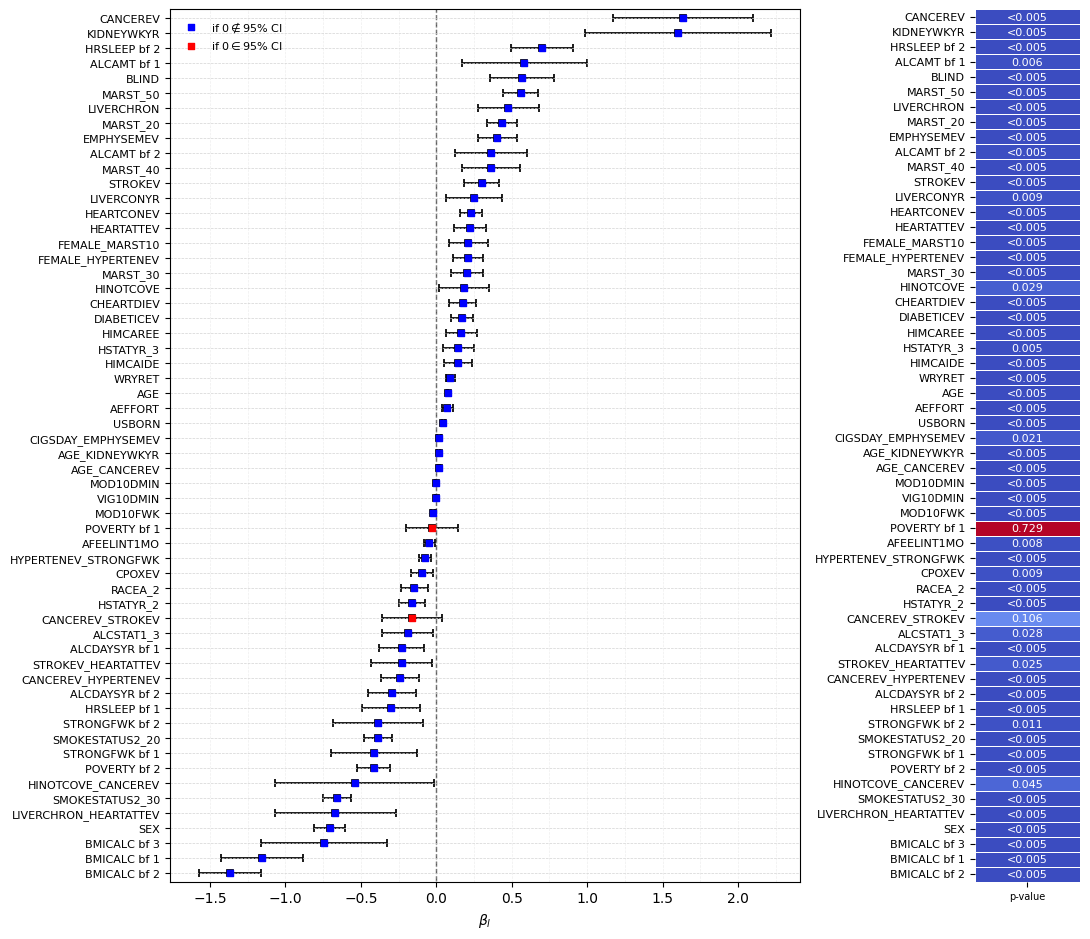

In [12]:
# extract coefficients, confidence intervals, and p-values
coefs = cph.summary[['coef', 'coef lower 95%', 'coef upper 95%']]
betas = cph.summary[['coef']]
p_values = cph.summary[['p']]  
l95 = cph.summary[['coef lower 95%']]
u95 = cph.summary[['coef upper 95%']]

# sort indices to match coefficient plot order
coefs = coefs.sort_values(by='coef', ascending=False)
p_values = p_values.loc[coefs.index]  
l95 = l95.loc[coefs.index]
u95 = u95.loc[coefs.index]

# replace p-values < 0.005 with '<0.005' annotation
p_values_annot = p_values.apply(lambda col: col.map(lambda x: '<0.005' if x < 0.005 else f'{x:.3f}'))

# create subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(11, 9.5), gridspec_kw={'width_ratios': [3, 0.5]})

# ---left plot---
cph.plot(ax=ax1, linestyle="", markersize=5)  

# get x (coefs) and y positions for points
x_vals = coefs['coef']
y_vals = np.arange(len(coefs))  

# identify significant markers (e.g., p-value < 0.05)
significant = u95['coef upper 95%']*l95['coef lower 95%'] >= 0
not_significant = u95['coef upper 95%']*l95['coef lower 95%'] < 0

x_plot_sig = x_vals[significant]
y_plot_sig = len(y_vals)-1-y_vals[significant]
x_plot_not_sig = x_vals[not_significant]
y_plot_not_sig = len(y_vals)-1-y_vals[not_significant]

# highlight significant markers in red
ax1.scatter(x_plot_sig, y_plot_sig, color="blue", marker='s', s=15, label=r"if $0\notin 95\%$ CI", zorder=3) 
ax1.scatter(x_plot_not_sig, y_plot_not_sig+0.02, color="red", marker='s', s=15, label=r"if $0\in 95\%$ CI", zorder=3) 
ax1.set_xlabel(r'$\beta_l$', fontsize=10)
ax1.tick_params(axis='y', labelsize=8)  
ax1.set_ylim(-0.6, len(y_vals)-0.4) 
ax1.legend(fontsize=8, loc="upper left", frameon=False)

# add horizontal grid lines across both plots
for y in range(len(coefs)+1):
    ax1.axhline(y-1, color='lightgrey', linestyle='--', linewidth=0.5, alpha=1)

sns.heatmap(p_values, ax=ax2, cmap='coolwarm', annot=p_values_annot, fmt="", cbar=False, linewidths=0.7,
            annot_kws={'size': 8}) 
ax2.set_ylabel('')  
ax2.set_xticklabels(['p-value'], fontsize=8, rotation=0)

# all y-ticks  displayed on the heatmap
ax2.set_yticks(np.arange(len(p_values)) + 0.5)  
ax2.set_yticklabels(p_values.index, fontsize=8)  
ax2.tick_params(axis='both', labelsize=7)

# add verical linear at coef values
for x in np.arange(-1.5, 2.5, 0.25):
    ax1.axvline(x=x, color='lightgrey', linestyle='--', linewidth=0.5, alpha=0.38)

#____________
# define custom labels for splines
spline_labels = {
    "bs(BMICALC, degree=2, df=3)[1]": "BMICALC bf 1",
    "bs(BMICALC, degree=2, df=3)[2]": "BMICALC bf 2",
    "bs(BMICALC, degree=2, df=3)[3]": "BMICALC bf 3",
    "bs(HRSLEEP, degree=1, df=2)[1]": "HRSLEEP bf 1",
    "bs(HRSLEEP, degree=1, df=2)[2]": "HRSLEEP bf 2",
    "bs(STRONGFWK, degree=2, df=2)[1]": "STRONGFWK bf 1",
    "bs(STRONGFWK, degree=2, df=2)[2]": "STRONGFWK bf 2",
    "bs(ALCDAYSYR, degree=1, df=2)[1]": "ALCDAYSYR bf 1",
    "bs(ALCDAYSYR, degree=1, df=2)[2]": "ALCDAYSYR bf 2",
    "bs(ALCAMT, degree=2, df=2)[1]": "ALCAMT bf 1", 
    "bs(ALCAMT, degree=2, df=2)[2]": "ALCAMT bf 2", 
    "bs(POVERTY, degree=2, df=2)[1]": "POVERTY bf 1",
    "bs(POVERTY, degree=2, df=2)[2]": "POVERTY bf 2",
}

# replace splines in coefficient and p-value indices
coefs.index = [spline_labels.get(x, x) for x in coefs.index]
p_values.index = coefs.index  # Ensure consistency

# update y-axis labels in both plots
ax1.set_yticklabels(coefs.index[::-1], fontsize=8) 
ax2.set_yticklabels(p_values.index, fontsize=8) 

#____________

plt.tight_layout()
plt.savefig('cph1.png', format='png', dpi=300, bbox_inches='tight')
plt.show()

In [13]:
# save for next model
df_train_cph4.to_csv("df_train_cph4.csv", index=False)
df_test_cph4.to_csv("df_test_cph4.csv", index=False)